In [1]:
import pandas as pd
import numpy as np
import scipy.stats as ss

import lightfm
import lightfm.data as ld
import lightfm.evaluation as lv

import glob
import tqdm
import json
import optuna

import tensorboardX as tb

import matplotlib.pyplot as pl
import seaborn as sns

np.random.seed(31337)

In [2]:
DATA_DIR = "/home/uyra/Desktop/recsys-course-spring-2024"

In [3]:
data = pd.concat([
    pd.read_json(data_path, lines=True) 
    for data_path 
    in glob.glob(DATA_DIR + "/data/*/data.json")
])
data["rnd"] = np.random.random(len(data))

data.head(5)

,message,timestamp,user,track,time,latency,recommendation,experiments,rnd
0,next,2024-03-04 09:06:00.860,4692,1725,0.12,0.001191,43584.0,{},0.721852
1,next,2024-03-04 09:06:01.046,5608,465,0.01,0.001766,2233.0,{},0.966441
2,next,2024-03-04 09:06:01.072,7957,14152,1.00,0.001588,14080.0,{},0.289049
3,next,2024-03-04 09:06:01.088,6487,41692,0.00,0.001369,41692.0,{},0.171346
4,next,2024-03-04 09:06:01.102,7957,46954,0.03,0.001266,6149.0,{},0.371618


In [4]:
positives = data[data["time"] > 0.5].copy()
positives["test"] = np.random.random(len(positives)) >= 0.7
positives.drop_duplicates(["user", "track"], inplace=True)

In [5]:
user_counts = positives[~positives["test"]].groupby("user").size()
users = set(user_counts[user_counts >= 5].index.values)

In [6]:
track_counts = positives[~positives["test"]].groupby("track").size()
tracks = set(track_counts[track_counts >= 5].index.values)

In [7]:
len(users), len(tracks)

(9697, 4520)

## Train LightFM

In [8]:
train_data = positives[~positives["test"] & positives["user"].isin(users) & positives["track"].isin(tracks)]
test_data = positives[positives["test"] & positives["user"].isin(users) & positives["track"].isin(tracks)]

len(train_data), len(test_data)

(67474, 26995)

In [9]:
dataset = ld.Dataset()
dataset.fit(users, tracks)

In [10]:
train_interactions, _ = dataset.build_interactions(train_data[["user", "track"]].itertuples(index=False, name=None))
test_interactions, _ = dataset.build_interactions(test_data[["user", "track"]].itertuples(index=False, name=None))

In [11]:
def fit_model(
    epochs=1, 
    at=10,
    loss="warp",
    no_components=30,
    learning_rate=0.01, 
    max_sampled=10,
    user_alpha=0.0, 
    item_alpha=0.0, 
    threads=30, 
    verbose=False,
    patience=3,
    epsilon=1e-6,
):
    model = lightfm.LightFM(
        no_components=no_components,
        loss=loss,
        learning_rate=learning_rate,
        max_sampled=max_sampled,
        user_alpha=user_alpha,
        item_alpha=item_alpha,
    )

    precisions_at = []
    
    for epoch in range(epochs):
        model = model.fit_partial(train_interactions, num_threads=threads)
        
        precision_at = lv.precision_at_k(model, test_interactions, train_interactions=train_interactions, k=at, num_threads=threads)
        
        if verbose:
            print(f"{epoch}:\t{np.mean(precision_at)} +/- {ss.sem(precision_at) * 1.96}")
            
        precisions_at.append(np.mean(precision_at))
            
        if epoch > patience and all([precisions_at[-j] - precisions_at[-patience-1] < epsilon for j in range(1, patience + 1)]):
            if verbose:
                print("Early stopiing!")
            break
        
    else:
        if verbose:
            print("No early stopiing happened: increase epochs maybe?")
        
    return model, precisions_at


def objective(trial):
    loss = trial.suggest_categorical("loss", ["warp", "bpr"])
    no_components = trial.suggest_categorical("no_components", [10, 30, 50])
    learning_rate = trial.suggest_categorical("learning_rate", [0.0001, 0.001, 0.01])
    max_sampled = trial.suggest_categorical("max_sampled", [10, 20, 50, 100])
    user_alpha = trial.suggest_categorical("user_alpha", [0.0, 0.0001])
    item_alpha = trial.suggest_categorical("item_alpha", [0.0, 0.0001])
    
    model, precisions_at = fit_model(
        epochs=5, 
        at=10,
        loss=loss,
        no_components=no_components, 
        learning_rate=learning_rate, 
        max_sampled=max_sampled, 
        user_alpha=user_alpha, 
        item_alpha=item_alpha,
    )
    
    return precisions_at[-1]

In [12]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)
best_params = study.best_params

[I 2024-04-12 17:56:29,051] A new study created in memory with name: no-name-21012993-dd73-450c-8dbc-63398aa7e703
[I 2024-04-12 17:56:29,523] Trial 0 finished with value: 0.018226156011223793 and parameters: {'loss': 'warp', 'no_components': 10, 'learning_rate': 0.01, 'max_sampled': 50, 'user_alpha': 0.0, 'item_alpha': 0.0001}. Best is trial 0 with value: 0.018226156011223793.
[I 2024-04-12 17:56:30,249] Trial 1 finished with value: 0.01795395277440548 and parameters: {'loss': 'warp', 'no_components': 50, 'learning_rate': 0.0001, 'max_sampled': 50, 'user_alpha': 0.0001, 'item_alpha': 0.0}. Best is trial 0 with value: 0.018226156011223793.
[I 2024-04-12 17:56:31,003] Trial 2 finished with value: 0.004559373948723078 and parameters: {'loss': 'bpr', 'no_components': 50, 'learning_rate': 0.01, 'max_sampled': 20, 'user_alpha': 0.0001, 'item_alpha': 0.0001}. Best is trial 0 with value: 0.018226156011223793.
[I 2024-04-12 17:56:31,748] Trial 3 finished with value: 0.0017466258723288774 and pa

In [13]:
# best_params = {
#     'loss': 'warp',
#     'no_components': 50,
#     'learning_rate': 0.01,
#     'max_sampled': 100,
#     'user_alpha': 0.0,
#     'item_alpha': 0.0001
# }

In [14]:
model, precisions_at = fit_model(
    epochs=300,
    at=50,
    loss=best_params["loss"],
    no_components=best_params["no_components"], 
    learning_rate=best_params["learning_rate"], 
    max_sampled=best_params["max_sampled"],
    user_alpha=best_params["user_alpha"],
    item_alpha=best_params["item_alpha"],
    verbose=True,
)

0:	0.01165022049099207 +/- 0.0004112736633100575
1:	0.011688783764839172 +/- 0.000412261758538999
2:	0.011829420924186707 +/- 0.00041658101072966435
3:	0.011874786578118801 +/- 0.000417867315229322
4:	0.012010887265205383 +/- 0.0004199989088756082
5:	0.012090278789401054 +/- 0.0004209585050960184
6:	0.012160598300397396 +/- 0.0004228190665615794
7:	0.012255867943167686 +/- 0.00042349005686066933
8:	0.012425994500517845 +/- 0.00042559579533550494
9:	0.01250084862112999 +/- 0.0004262426023012982
10:	0.01266870740801096 +/- 0.0004274206650004769
11:	0.012827491387724876 +/- 0.0004291000458660982
12:	0.012877395376563072 +/- 0.0004283097718587217
13:	0.012974933721125126 +/- 0.0004290803337278644
14:	0.013083814643323421 +/- 0.0004305856101457325
15:	0.013179084286093712 +/- 0.0004313389870738508
16:	0.013258477672934532 +/- 0.0004307137196042735
17:	0.013367357663810253 +/- 0.0004326850500675229
18:	0.01355563011020422 +/- 0.0004338547146959748
19:	0.013680389150977135 +/- 0.0004349946361

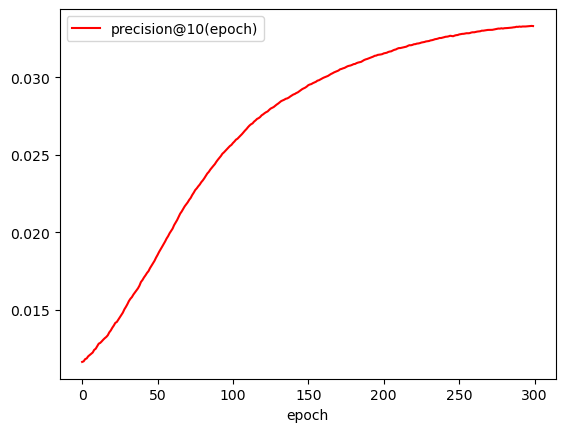

In [15]:
# TODO 1.4: Plot learning curve precision@k(epoch)
figure, ax = pl.subplots()

ax.plot(list(range(len(precisions_at))), precisions_at, "r", label="precision@10(epoch)")

ax.set_xlabel("epoch")
ax.legend()

pass

## Save track embeddings

In [16]:
BOTIFY_DATA_DIR = "/home/uyra/Desktop/recsys-course-spring-2024/botify/data/"

In [17]:
biases, embeddings = model.get_item_representations()

In [18]:
model.item_biases *= 0.0

In [19]:
track_meta = pd.read_json(BOTIFY_DATA_DIR + "tracks.json", lines=True)
track_meta["dataset_index"] = track_meta["track"].map(lambda t: dataset.mapping()[2].get(t))

In [20]:
dataset_tracks = track_meta[pd.notnull(track_meta["dataset_index"])].sort_values("dataset_index")

In [21]:
writer = tb.SummaryWriter(comment='msd_ligtfm_embeddings', log_dir="/home/uyra/Desktop/recsys-course-spring-2024/jupyter/content")
writer.add_embedding(embeddings, metadata=list(dataset_tracks[["artist", "title"]].itertuples(index=False, name=None)), tag="lightfm", metadata_header=["artist", "title"])
writer.close()

## Compute top recommendations

In [22]:
tracks = dataset_tracks["track"].values
users = [user for user, index in sorted(dataset.mapping()[0].items(), key=lambda kv: kv[1])]

In [23]:
with open(BOTIFY_DATA_DIR + "recommendations_lfm.json", "w") as rf:
    for user_index in tqdm.tqdm(range(dataset.user_features_shape()[0])):
        predictions = model.predict(user_index, np.arange(dataset.item_features_shape()[0]), num_threads=30)
        top = tracks[np.argsort(predictions)[-30:]]
        recommendation = {
            "user": int(users[user_index]),
            "tracks": [int(x) for x in top]
        }
        rf.write(json.dumps(recommendation) + "\n")

  1%|          | 103/9697 [00:00<00:09, 1029.08it/s]

100%|██████████| 9697/9697 [00:05<00:00, 1847.01it/s]
